# 1.2 Data

In [1]:
from datasets import Dataset, DatasetDict

/mnt/lustre/yuxin/anaconda3/envs/sc4002/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# read data
def read_conll_file(file_path):
    with open(file_path, "r") as f:
        content = f.read().strip()
        sentences = content.split("\n\n")
        data = []
        for sentence in sentences:
            tokens = sentence.split("\n")
            token_data = []
            for token in tokens:
                token_data.append(token.split())
            data.append(token_data)
    return data

train_data = read_conll_file("/mnt/lustre/yuxin/SC4002_G06/datasets/CoNLL2003/eng.train")
validation_data = read_conll_file("/mnt/lustre/yuxin/SC4002_G06/datasets/CoNLL2003/eng.testa")
test_data = read_conll_file("/mnt/lustre/yuxin/SC4002_G06/datasets/CoNLL2003/eng.testb")

In [3]:
# prepare data
def convert_to_dataset(data, label_map):
    formatted_data = {"tokens": [], "ner_tags": []}
    for sentence in data:
        tokens = [token_data[0] for token_data in sentence]
        ner_tags = [label_map[token_data[3]] for token_data in sentence]
        formatted_data["tokens"].append(tokens)
        formatted_data["ner_tags"].append(ner_tags)
    return Dataset.from_dict(formatted_data)

label_list = sorted(list(set([token_data[3] for sentence in train_data for token_data in sentence])))
label_map = {label: i for i, label in enumerate(label_list)}

train_dataset = convert_to_dataset(train_data, label_map)
validation_dataset = convert_to_dataset(validation_data, label_map)
test_dataset = convert_to_dataset(test_data, label_map)

## Question 1.2
(a) Describe the size (number of sentences) of the training, development and test file for CoNLL2003.
Specify the complete set of all possible word labels based on the tagging scheme (IO, BIO,
etc.) you chos

(b) Choose an example sentence from the training set of CoNLL2003 that has at least two named
entities with more than one word. Explain how to form complete named entities from the label
for each word, and list all the named entities in this sentence.e.

In [4]:
# (a)
print("Dataset Sizes:")
print(f"Training:\t{train_dataset.num_rows} sentences")
print(f"Development:\t{validation_dataset.num_rows} sentences")
print(f"Test:\t\t{test_dataset.num_rows} sentences")

print("=======================================================================")
print("All Possible Word Labels (BIO):\n", label_list)

Dataset Sizes:
Training:	14987 sentences
Development:	3466 sentences
Test:		3684 sentences
All Possible Word Labels (BIO):
 ['B-LOC', 'B-MISC', 'B-ORG', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']


In [6]:
from tqdm import tqdm
lists2 = [0,1,2] # ['B-LOC', 'B-MISC', 'B-ORG']

def has_at_least_two_common_elements(list1, list2=[0,1,2]):
    common_elements = [value for value in list1 if value in list2]
    return len(common_elements) >= 2
    
for i in tqdm(range(len(train_dataset))):
    tokens = train_dataset['tokens'][i]
    ner_tags = train_dataset['ner_tags'][i]

    if has_at_least_two_common_elements(ner_tags):
        print(i)
        print(tokens)
        print(ner_tags)
        print([label_list[tag] for tag in ner_tags])
        break

 40%|██████████████████████████▎                                       | 5969/14987 [18:51<28:30,  5.27it/s]

5969
['Swiss', 'Grand', 'Prix', 'World', 'Cup', 'cycling', 'race', 'on', 'Sunday', ':']
[4, 1, 4, 1, 4, 7, 7, 7, 7, 7]
['I-MISC', 'B-MISC', 'I-MISC', 'B-MISC', 'I-MISC', 'O', 'O', 'O', 'O', 'O']


In [7]:
# (b)
def form_complete_ne(dataset, i):
    # define sets of tags
    begin_tags = {'B-LOC', 'B-ORG', 'B-MISC'}
    inside_tags = {'I-ORG', 'I-LOC', 'I-PER', 'I-MISC'}
    outside_tags = {'O'}
    
    words = []
    word = []
    entities = []
    entity = []
    
    tokens = dataset['tokens'][i]
    ner_tags = dataset['ner_tags'][i]
    
    for token, tag in zip(tokens, ner_tags):
        tag = label_list[tag]
        
        if (tag in begin_tags or tag in outside_tags) and word:
            words.append(' '.join(word))
            entities.append(' '.join(entity))
            word = []
            entity = []
            
        if tag in begin_tags or tag in inside_tags:
            word.append(token)
            entity.append(tag)
            
    if word:
        words.append(' '.join(word))
        entities.append(' ', join(entity))

    return words, entities

print(form_complete_ne(train_dataset, 5969))

(['Swiss', 'Grand Prix', 'World Cup'], ['I-MISC', 'B-MISC I-MISC', 'B-MISC I-MISC'])


# EDA on train dataset

In [8]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

In [9]:
# Flattening the lists of tokens and tags
all_tokens = [token for sentence in train_dataset['tokens'] for token in sentence]
all_tags = [tag for sentence_tags in train_dataset['ner_tags'] for tag in sentence_tags]

word_frequencies = Counter(all_tokens)
common_words_gt_10 = {word: freq for word, freq in word_frequencies.items() if freq > 10}
unique_words = set(all_tokens)

sentence_lengths = [len(sentence) for sentence in train_dataset['tokens']]
average_sentence_length = sum(sentence_lengths) / len(sentence_lengths)

print("Basic info about the training corpora:")
print("=======================================================================")
print("Number of sentences: ", train_dataset.num_rows)
print("Total NER tags: ", len(label_list))
print("Number of common words with frequency > 10: ", len(common_words_gt_10))
print("Number of unique words in corpus: ", len(unique_words))
print("Average sentence length: ", average_sentence_length)

Basic info about the training corpora:
Number of sentences:  14987
Total NER tags:  8
Number of common words with frequency > 10:  2254
Number of unique words in corpus:  23624
Average sentence length:  13.649629679055181


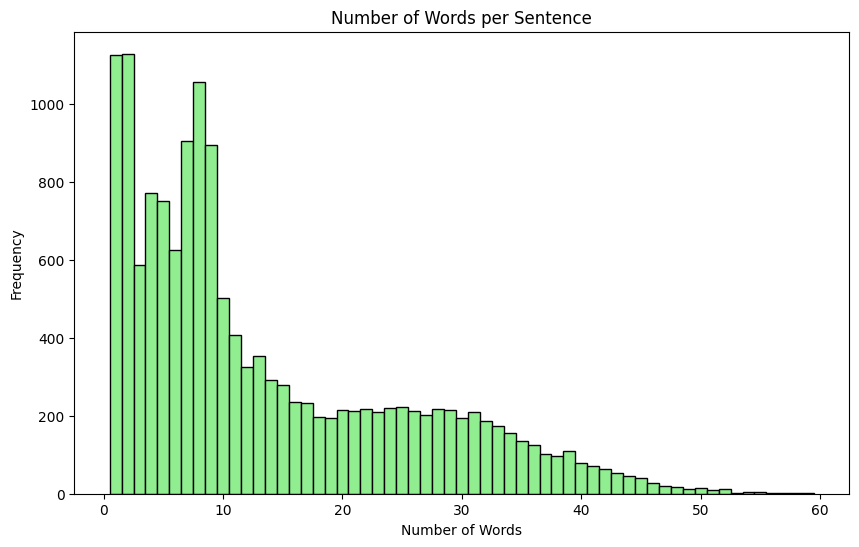

In [35]:
# Plot Number of Words per Sentence
sentence_lengths = [len(sentence) for sentence in train_dataset['tokens']]
plt.figure(figsize=(10, 6))
# plt.hist(sentence_lengths, bins=np.arange(1, max(sentence_lengths) + 1) - 0.5, edgecolor="k")
plt.hist(sentence_lengths, bins=np.arange(1, 60 + 1) - 0.5, edgecolor="k", color='lightgreen')
plt.title('Number of Words per Sentence')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [28]:
tags_counter = Counter(all_tags)

# map number to strings
num_to_str_label_map = {v: k for k, v in label_map.items()}

# convert numerical labels to string labels
tags_counter_str = {num_to_str_label_map[num]: count for num, count in tags_counter.items()}
tags_counter_str

{'I-ORG': 10001,
 'O': 170524,
 'I-MISC': 4558,
 'I-PER': 11128,
 'I-LOC': 8286,
 'B-LOC': 11,
 'B-MISC': 35,
 'B-ORG': 24}

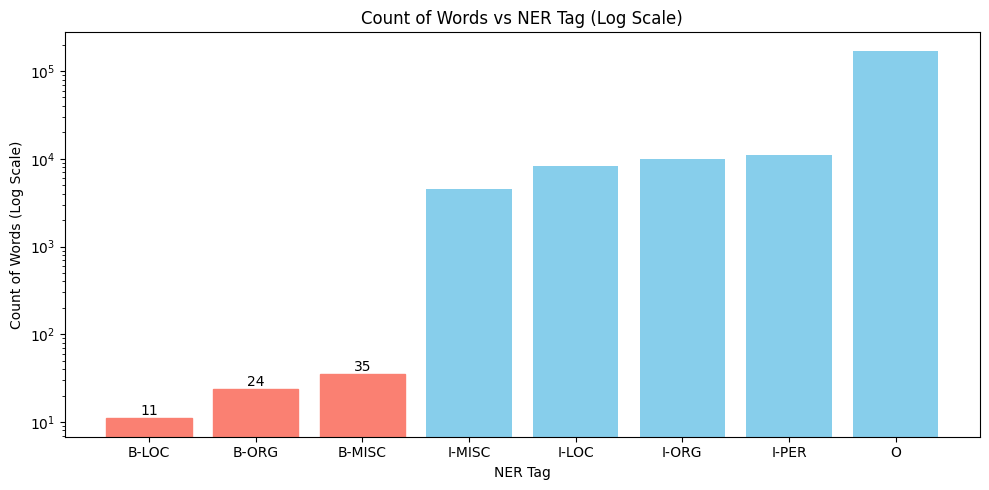

In [29]:
# Sorting the tags counter by count for better visualization
tags_counter_sorted = dict(sorted(tags_counter_str.items(), key=lambda item: item[1]))

# Creating the bar plot with a logarithmic y-axis
plt.figure(figsize=(10, 5))
bars = plt.bar(tags_counter_sorted.keys(), tags_counter_sorted.values(), color='skyblue')

# Highlighting the 'B-' tags
for bar, label in zip(bars, tags_counter_sorted.keys()):
    if label.startswith('B-'):
        bar.set_color('salmon')

plt.yscale('log')
plt.xlabel('NER Tag')
plt.ylabel('Count of Words (Log Scale)')
plt.title('Count of Words vs NER Tag (Log Scale)')
plt.tight_layout()

# Adding annotations for the 'B-' tags
for label, count in tags_counter_sorted.items():
    if label.startswith('B-'):
        plt.text(label, count, f'{count}', ha='center', va='bottom')

# Show the plot
plt.show()